In [13]:
import pandas as pd
import numpy as np
import json
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob

pd.options.display.max_rows = 200

sns.set_style('whitegrid')
plt.style.use('Cole_2018.mplstyle')

# 1. Load processed purchase data

In [14]:
df = pd.read_csv('/gh/data/personal-data-requests/BoA/web_pdf_merge.csv', index_col=0, parse_dates=['date'])
df = df.sort_values(by='date').reset_index(drop=True)
df.head()

,city,amount,date,description,pdf_category,Original Description,Category,Account Name,Simple Description
0,"AMZN.COM/BIL,WA",22.63,2013-04-26,AMAZON MKTPLACE PMTS,NaN,NaN,NaN,NaN,NaN
1,"AMZN.COM/BIL,WA",223.49,2013-04-26,AMAZON MKTPLACE PMTS,NaN,NaN,NaN,NaN,NaN
2,"609-771-7670,NJ",185.00,2013-04-29,ETS*GRE TEST SERVICES,NaN,NaN,NaN,NaN,NaN
3,"CLEMSON,SC",22.96,2013-04-29,RUBY TUESDAY #4214,NaN,NaN,NaN,NaN,NaN
4,"CLEMSON,SC",33.12,2013-04-29,BI-LO 539,NaN,NaN,NaN,NaN,NaN


# 2. Process category

In [15]:
key_to_cat = [('Grocery', ['ralphs', 'trader joe', 'sprouts', '99 ranch', 'bi-lo', 'shoprite', 'supermarket', 'walmrt',
                           'wal-mart', 'target', 'vons', 'supercenter', 'publix', 'grocery', 'zion', 'fairway', 'kroger',
                           'h mart', 'albertsons']),
              ('Amazon', ['amazon', 'amz*', 'amzn']),
              ('Clothes', ['society6', 'laundry', 'kohl', 'uq powell', 'h&m', 'h & m']),
              ('Costco', ['costco']),
              ('Thai', ['thai', 'blue pepper', 'pok pok', 'pestle rock', 'siam', 'lemongrass',
                        'chi extraordinary', 'sab-e-lee']),
              ('Vietnamese', ['k sandwich', 'vietnam', 'pho', 'banh mi', 'bon me', 'shallot asian']),
              ('Dessert', ['dessert', 'iceskimo', 'grace street', 'bobboi', 'halva', 'paris baguette', 'hungry bear',
                           '55 exchange', 'icea cream', 'molly moon', 'dairy queen', "rita's water", 'ritas water',
                           'ritas 990', 'full tilt ice', 'beavertails', 'gelato', 'milk', 'jamba juice', 'seed mill',
                           'azucar']),
              ('Boba', ['tapioca', 'sharetea', 'bubble tea', '85c', 'dingtea', 'tea do', 'kung fu tea',
                        'tasty pot', 'guiltea','chatime', 'infusion tea']),
              ('Mexican', ['taco villa', 'vallarta', 'rigoberto', 'los primos' ,'burrito',
                           'taco', 'lucha libre', 'zarape', 'chipotle', 'rubio', 'porkyland', 'mexico', 'mexican',
                           'pollo loco', 'dos caballeros', 'burro', 'panchos', 'grubby', 'el jimador', 'takorea',
                           'bonitas', 'el vez', 'cotixan', 'agua verde', 'tortilla', 'el nopalito', 'carmens authentic mex',
                           'pollos maria', 'el toritos', 'el patron', 'lolas 7-up', 'cocina']),
              ('Japanese', ['raku dupont', 'aki nom', 'sushi', 'shogun', 'tokyo', 'japan', 'subarashi', 'izakaya', 'ramen', 'hinotez',
                            'cucina', 'nozomi', 'osaka', 'yakyudori', 'natsumi', 'katsuya', 'okandiner', 'daikaya',
                            'teri cafe', 'wasabi', 'katsu', 'cocoichi', 'shi-shi', 'go go curry', 'momofuku']),
              ('Italian', ['pizza', 'italian', 'cafe milano', 'woodfired', 'pisillo', 'dominos', 'pizzeria',
                           'pasta', 'brioso', 'zia bistro', 'villa fik', 'carmines west 44']),
              ('Chinese', ['panda express', 'china', 'noodle', 'tofu', 'sunhing', 'fuan garden', 'mandarin',
                           'red bowl', 'xian', 'luxe buffet', 'din tai fung', 'dim sum', 'tim ho wan',
                           'asian delight', 'genghis', 'taste of yunnan', 'chinese', 'junzi', 'shanghai',
                           'han dynasty', 'wok', 'nom wah kuai', 'pnda exp', 'nong s khao man', 'da hong pao']),
              ('Poke', ['poke', 'poki']),
              ('Korean', ['friends house', 'krispy krunchy', 'misono grill']),
              ('Hawaiian', ['tasty crust', 'laulau', 'hi seafood', 'sam sato', 'broke da mouth']),
              ('American', ['boudin', 'mulberry and vine', 'ruby tuesday', 'texas', 'jersey mike', 'dennys', 'melting pot', 'chickies petes', 'seedand', 'savor-mccormick','smokin pig',
                            'subway', 'dominos', 'papa john', 'dlush', 'croutons', 'pea soup',
                            'souplant', 'soda & swine', 'bagels', 'potbelly', 'pot belly', 'bristol farm', 
                            'urban plate', 'shake shack', 'cheesesteak', 'coopers tavern', 'bbq', 'hoagie',
                            'dirty bird', 'seasons 52', 'hash house', 'bella vista', 'pure burger', 'dig inn',
                            'tops diner', 'islands', 'nevada diner', 'dlux', 'habit burger', 'philly',
                            'sweetgreen', 'tgi friday', 'cleavers', 'hershels', 'broken yolk', 'chopt',
                            'club med', 'goodys', 'uw madison dining', 'bliss bowl', 'blimpie']),
              ('Seafood', ['craw fish', 'fish market', 'bali hai', 'go fish', 'el pescador']),
              ('Latin American', ['havana', 'fogo de', 'cuban', 'flordemayo', 'empanada', 'arepa', 'carne argentina',
                                  'jamaican']),
              ('Indian', ['bombay', 'dishoom', 'boishakhi', 'tandoori', 'india', 'punjabi']),
              ('Fast food', ['chick-fil-a', 'arbys', 'in-n-out', 'in n out', 'wendys', 'jack in the box',
                             'burger king', 'mcdonald', 'whataburger', 'carls jr']),
              ('African', ['muzita abyss', 'flavors or east af', 'keren restaurant', 'queen of sheba']),
              ('Meditteranean', ['falafel', 'kebab', 'shawarma', 'zanzibar', 'kabab', 'havruta', 'uncle momo',
                                 'helmand', 'nish nush', 'misterfal', 'halal guys', 'santorini', 'medaterra',
                                 'pegasus on the fly', 'pierogies', 'simsim']),
              ('German', ['tip top', 'stammtisch', 'bavaria']),
              ('French', ['buvette', 'monsieur', 'paris crepe', 'creperie']),
              ('Other food', ['diner', 'cafe', 'restaurant', 'washington dc cc rest', 
                              'carmen', 'soylent', 'wawa', '7-eleven', 'burger',  'letoile', 
                              'ballast point', 'general store', 'baguette', 'pancake' , 'yelpinc', 'shopyelp',
                              ]),
              ('Uber', ['uber', 'lyft']),
              ('Transit', ['mta mv', 'yellocab', 'taxi']),
              ('Auto', ['clairemont auto', 'parking', 'geico', 'dmv', 'westmart', 'fuel', 'pepboys',
                        'motor', 'toyota', 'sheetz', 'exxon', 'sunoco', 'lake keowee', 'stop-a-minit', 'shell']),
              ('Travel', ['hostel', 'gsp airport', 'turo', 'airlines', 'united', 'airbnb', 'alaska air',
                          'southwes', 'usair', 'hawaiian ai', 'westjet', 'american air', 'delta air', 'amtrak',
                          'his tours', 'duo hous', 'le village', 'shelter city', 'rail europe', 'tel aviv',
                          'sandemans', 'museums']),
              ('Donations', ['patreon', 'dejill stein']),
              ('Health', ['ucsd student health', 'mychart', 'campusthornton', 'ambulance', 'ucsd med',
                          'eye & contact', 'dental', 'medical']),
              ('Utilities', ['twctime'])
             ]

def description_to_category(x):
    for k, strs in key_to_cat:
        for s in strs:
            if s in x:
                return k

df['description_category'] = df['description'].str.lower().apply(description_to_category)

df['Category'] = df['Category'].replace({'Other Expenses': None})
df['Category'] = df['Category'].replace({'Uncategorized': None})
df['category'] = df['description_category'].combine_first(df['Category']).combine_first(df['pdf_category'])

df['category'] = df['category'].replace({'Health Care': 'Health',
                                                'Pharmacy': 'Health',
                                                'Healthcare/Medical': 'Health',
                                                'Clothing/Shoes': 'Clothes',
                                                'Clothing': 'Clothes',
                                                'Other Stores/Retail': 'Clothes',
                                                'Gas Station': 'Auto',
                                                'Other Travel/Transportation': 'Travel',
                                                'Travel': 'Travel',
                                                'Hotels': 'Travel',
                                                'Food Store': 'Grocery',
                                                'Groceries': 'Grocery',
                                                'Restaurants/Dining': 'Other food',
                                                'Dining': 'Other food',
                                                'Gasoline/Fuel': 'Auto',
                                                'Charitable Giving': 'Donations',
                                                'Department Store': 'Clothes',
                                                'Entertainment': 'Other',
                                                'Home Maintenance': 'Other',
                                                'Home Improvement': 'Other',
                                                'Education': 'Other',
                                                'Online Services': 'Other',
                                                'General Merchandise': 'Other',
                                                'Recreation': 'Other',
                                                'Hobbies': 'Other',
                                                'Electronics': 'Other',
                                                'Taxes': 'Other',
                                                'Cable/Satellite Services': 'Other',
                                                'Utilities': 'Other',
                                                'Services': 'Other'})

cols_keep = ['date', 'amount', 'category', 'description', 'city']
df = df[cols_keep]
df.head()

,date,amount,category,description,city
0,2013-04-26,22.63,Amazon,AMAZON MKTPLACE PMTS,"AMZN.COM/BIL,WA"
1,2013-04-26,223.49,Amazon,AMAZON MKTPLACE PMTS,"AMZN.COM/BIL,WA"
2,2013-04-29,185.00,NaN,ETS*GRE TEST SERVICES,"609-771-7670,NJ"
3,2013-04-29,22.96,American,RUBY TUESDAY #4214,"CLEMSON,SC"
4,2013-04-29,33.12,Grocery,BI-LO 539,"CLEMSON,SC"


# 3. Visualize cuisines

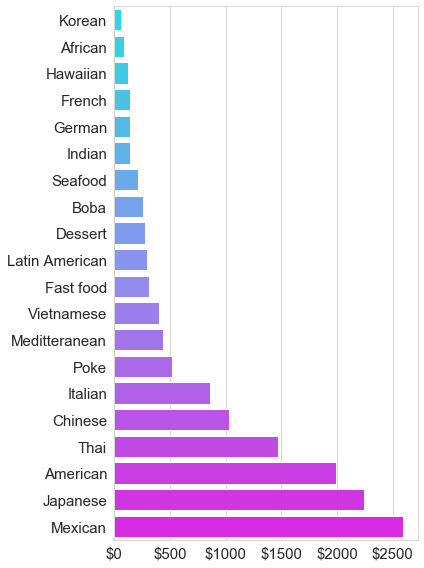

In [16]:
df_plt = df.copy()
food_keep = ['Mexican', 'Thai', 'Japanese', 'Italian', 'Chinese', 'Poke', 'Dessert', 'Boba', 'Vietnamese',
             'Korean', 'Hawaiian', 'African', 'French', 'Seafood', 'German', 'Latin American', 'Meditteranean', 'Fast food',
            'Indian', 'American']
df_plt = df_plt[df_plt['category'].isin(food_keep)]
df_plt = df_plt.groupby('category')['amount'].sum().sort_values().reset_index()

plt.figure(figsize=(6,8))
sns.barplot(x='amount', y='category', data=df_plt,
            palette=sns.color_palette('cool', n_colors=len(df_plt)))
plt.ylabel('')
plt.xlabel('')

# dollar ticks
import matplotlib.ticker as ticker
formatter = ticker.FormatStrFormatter('$%1.0f')
plt.gca().xaxis.set_major_formatter(formatter)
plt.tight_layout()

plt.savefig('/gh/srcole.github.io/assets/personaldata/boa_cuisines.png')

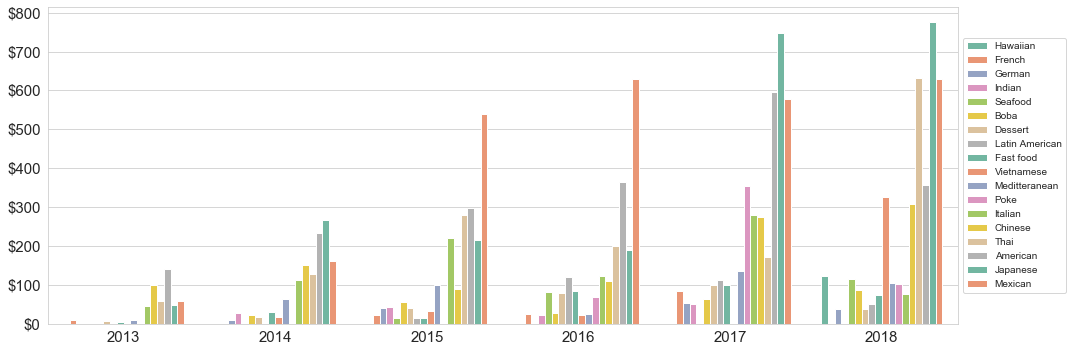

In [17]:
df_plt = df.copy()
df_plt['year'] = df_plt['date'].dt.year
df_plt = df_plt[df_plt['category'].isin(food_keep)].rename(columns={'category': 'cuisine'})
df_plt = df_plt.groupby(['cuisine', 'year'])['amount'].sum().sort_values().reset_index()

# Determine cuisines to plot
min_amt = 100
amt_per_cuisine = df_plt.groupby('cuisine')['amount'].sum()
cuisines_plt = amt_per_cuisine[amt_per_cuisine>min_amt].index
df_plt = df_plt[df_plt['cuisine'].isin(cuisines_plt)]

plt.figure(figsize=(15,5))
sns.barplot(x='year', y='amount', hue='cuisine', data=df_plt,
            hue_order=df_plt.groupby('cuisine')['amount'].sum().sort_values().index,
            palette=sns.color_palette('Set2', n_colors=df_plt['cuisine'].nunique())
           )
plt.ylabel('')
plt.xlabel('')

# dollar ticks
import matplotlib.ticker as ticker
formatter = ticker.FormatStrFormatter('$%1.0f')
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.tight_layout()

plt.savefig('/gh/srcole.github.io/assets/personaldata/boa_cuisines_by_year_bar.png')

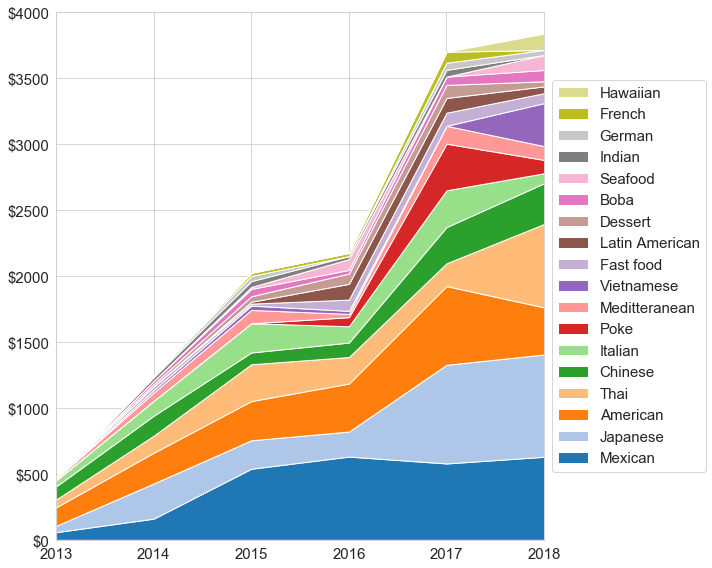

In [18]:
# Make data
df_plt2 = df_plt.pivot(index='year', columns='cuisine', values='amount').fillna(0)
df_plt2 = df_plt2[df_plt2.sum().sort_values(ascending=False).index]

# Make the plot
pal = sns.color_palette("tab20", n_colors=len(df_plt2.columns))
plt.figure(figsize=(10,8))
plt.stackplot(range(2013,2019), [df_plt2[c].values for c in df_plt2.columns], labels=df_plt2.columns,
              colors=pal)
plt.xlim((2013, 2018))
plt.ylim((0, 4000))

# dollar ticks
import matplotlib.ticker as ticker
formatter = ticker.FormatStrFormatter('$%1.0f')
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend(loc='center left', bbox_to_anchor=(1,.5))

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1,.5), fontsize=15)
plt.tight_layout()

plt.savefig('/gh/srcole.github.io/assets/personaldata/boa_cuisines_by_year_total_stacked.png')

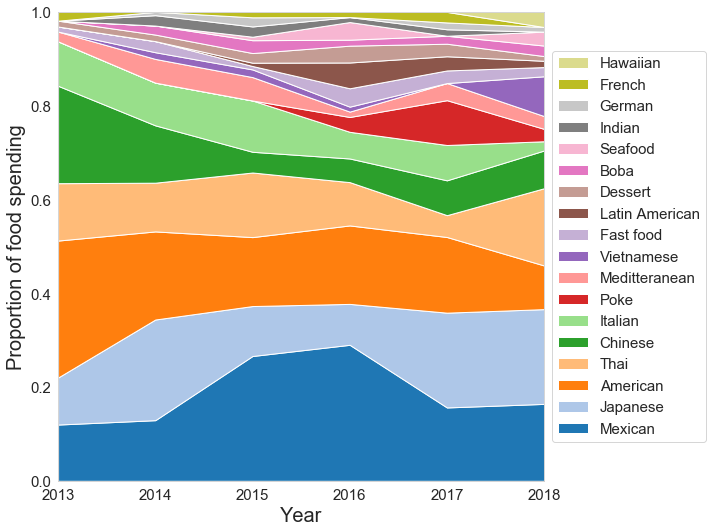

In [19]:
# We need to transform the data from raw data to percentage (fraction)
df_plt3 = df_plt2.divide(df_plt2.sum(axis=1), axis=0)

# Make the plot
plt.figure(figsize=(10,7.5))
plt.stackplot(range(2013,2019), [df_plt3[c].values for c in df_plt3.columns], labels=df_plt3.columns,
              colors=pal)
plt.xlim((2013, 2018))
plt.ylim((0, 1))
plt.yticks(np.arange(0,1.2,.2))
plt.ylabel('Proportion of food spending')
plt.xlabel('Year')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1,.5), fontsize=15)
plt.tight_layout()

plt.savefig('/gh/srcole.github.io/assets/personaldata/boa_cuisines_stacked_proportion.png')

# 4. Visualize categories

In [20]:
df_plt = df.copy()
df_plt['category'] = df_plt['category'].replace(food_keep, 'Dining')
df_plt['category'] = df_plt['category'].replace('Uber', 'Transit')
df_plt['category'] = df_plt['category'].replace('Costco', 'Grocery')
df_plt['category'] = df_plt['category'].replace(['Amazon', 'Clothes'], 'Shopping')
df_plt = df_plt[~df_plt['category'].isin(['Donations', 'Other'])]

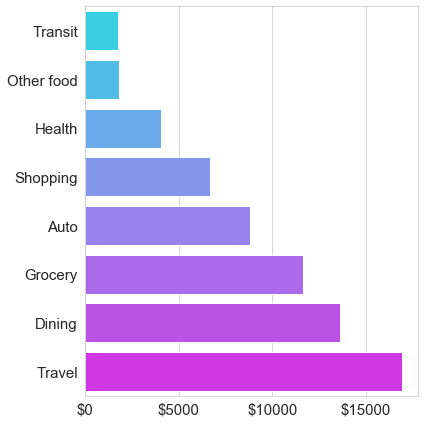

In [21]:
df_plta = df_plt.groupby('category')['amount'].sum().sort_values().reset_index()

plt.figure(figsize=(6,6))
sns.barplot(x='amount', y='category', data=df_plta,
            palette=sns.color_palette('cool', n_colors=len(df_plta)))
plt.ylabel('')
plt.xlabel('')


# dollar ticks
import matplotlib.ticker as ticker
formatter = ticker.FormatStrFormatter('$%1.0f')
plt.gca().xaxis.set_major_formatter(formatter)
plt.tight_layout()

plt.savefig('/gh/srcole.github.io/assets/personaldata/boa_categories_amount.png')

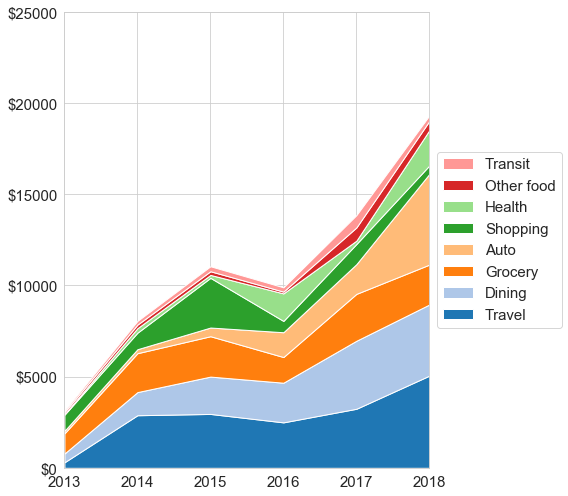

In [22]:
# Make data
df_pltb = df_plt.copy()
df_pltb['year'] = df_pltb['date'].dt.year
df_pltb = df_pltb.groupby(['year', 'category'])['amount'].sum().reset_index()
df_plt2 = df_pltb.pivot(index='year', columns='category', values='amount').fillna(0)
df_plt2 = df_plt2[df_plt2.sum().sort_values(ascending=False).index]

# Make the plot
pal = sns.color_palette("tab20", n_colors=len(df_plt2.columns))
plt.figure(figsize=(8,7))
plt.stackplot(range(2013,2019), [df_plt2[c].values for c in df_plt2.columns], labels=df_plt2.columns,
              colors=pal)
plt.xlim((2013, 2018))
plt.ylim((0, 25000))

# dollar ticks
import matplotlib.ticker as ticker
formatter = ticker.FormatStrFormatter('$%1.0f')
plt.gca().yaxis.set_major_formatter(formatter)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1,.5), fontsize=15)
plt.tight_layout()

plt.savefig('/gh/srcole.github.io/assets/personaldata/boa_categories_year_total.png')

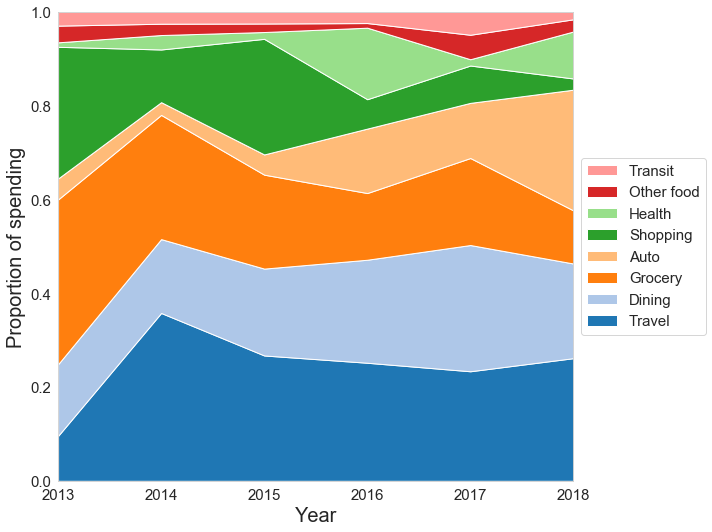

In [23]:
# We need to transform the data from raw data to percentage (fraction)
df_plt3 = df_plt2.divide(df_plt2.sum(axis=1), axis=0)

# Make the plot
plt.figure(figsize=(10,7.5))
plt.stackplot(range(2013,2019), [df_plt3[c].values for c in df_plt3.columns], labels=df_plt3.columns,
              colors=pal)
plt.xlim((2013, 2018))
plt.ylim((0, 1))
plt.yticks(np.arange(0,1.2,.2))
plt.ylabel('Proportion of spending')
plt.xlabel('Year')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1,.5), fontsize=15)
plt.tight_layout()

plt.savefig('/gh/srcole.github.io/assets/personaldata/boa_categories_year_proportion.png')